In [0]:
import pickle

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
def unpickle(file):
    
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
        
    return cifar_dict

In [0]:
file_path = "/content/drive/My Drive/Projects/MachineLearning/CNN/cifar-10-batches-py/"

In [0]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']
all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(file_path+direc)

In [0]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]


In [124]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [125]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [0]:
X1 = data_batch1[b'data']
X2 = data_batch2[b'data']
X3 = data_batch3[b'data']
X4 = data_batch4[b'data']
X5 = data_batch5[b'data']



In [0]:

X1 = X1.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
X2 = X2.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
X3 = X3.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
X4 = X4.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
X5 = X5.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

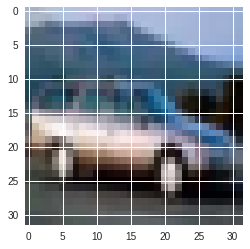

In [129]:
plt.imshow(X1[4])

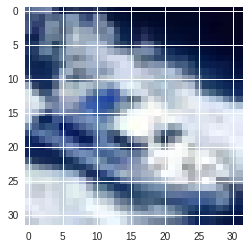

In [130]:
plt.imshow(X2[4])

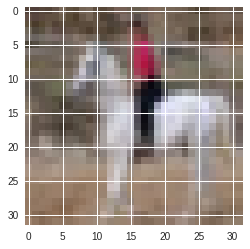

In [131]:
plt.imshow(X5[45])

In [0]:
def one_hot_encode(vec, vals=10):
  
  n = len(vec)
  out = np.zeros((n, vals))
  out[range(n), vec] = 1
  
  return out
  

In [0]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [172]:
cifarHelper = CifarHelper()
cifarHelper.set_up_images()


Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [0]:
###################### TENSORFLOW PART ##########

In [0]:
import tensorflow as tf

In [0]:
#PLACEHOLERS
X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
Y_true = tf.placeholder(dtype=tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

In [0]:
## intialize weights
def init_weights(shape):
  init_random = tf.truncated_normal(shape, stddev=0.09)
  return tf.Variable(init_random)

## initiailze bias

def init_bias(shape):
  init_ = tf.constant(0.1, shape=shape)
  return tf.Variable(init_)

In [0]:
def conv2d(X, W):
  return tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME')

def max_pooling(X):
  return tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [0]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [0]:
def fully_connected_layer(input, size):
  
  input_size = int(input.get_shape()[1])
  
  W = init_weights([input_size, size])
  b = init_bias([size])
  
  A = tf.matmul(input, W) + b
  
  return A

In [191]:
convolution_1 = convolutional_layer(X, shape=[4,4,3,32])
print(convolution_1.shape)
max_pooling_1 = max_pooling(convolution_1)
print(max_pooling_1.shape)

(?, 32, 32, 32)
(?, 16, 16, 32)


In [192]:
convolution_2 = convolutional_layer(max_pooling_1, shape=[4,4,32,64])
print(convolution_2.shape)
max_poolong_2 = max_pooling(convolution_2)

(?, 16, 16, 64)


In [0]:
convolution_to_flat = tf.reshape(max_poolong_2, shape=[-1, 8*8*64])

In [0]:
fully_connected = tf.nn.relu(fully_connected_layer(convolution_to_flat, 1024))

In [0]:
fully_connected_dropout = tf.nn.dropout(fully_connected, keep_prob=keep_prob)

In [0]:
y_pred = fully_connected_layer(fully_connected_dropout, 10)

In [0]:
cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=Y_true))

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy_loss)

In [0]:
init = tf.global_variables_initializer()

In [200]:
with tf.Session() as sess:
  sess.run(init)
  
  steps = 5000
  
  for i in range(steps):
    batch = cifarHelper.next_batch(100)
    
    sess.run(train, feed_dict={X:batch[0], Y_true:batch[1], keep_prob:0.50})
    
    if i % 100 == 0:
      print('Currently in step {}'.format(i))
      print("Accuracy is: ")
      
      matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(Y_true, 1))
      
      acc = tf.reduce_mean(tf.cast(matches, tf.float32))
      #sess.run(acc)
      
      print(sess.run(acc, feed_dict={X:cifarHelper.test_images, Y_true:cifarHelper.test_labels, keep_prob:1.0}))
      
      print('\n')

Currently in step 0
Accuracy is: 
0.1


Currently in step 100
Accuracy is: 
0.4128


Currently in step 200
Accuracy is: 
0.4744


Currently in step 300
Accuracy is: 
0.5074


Currently in step 400
Accuracy is: 
0.5363


Currently in step 500
Accuracy is: 
0.5651


Currently in step 600
Accuracy is: 
0.5734


Currently in step 700
Accuracy is: 
0.5905


Currently in step 800
Accuracy is: 
0.5983


Currently in step 900
Accuracy is: 
0.6028


Currently in step 1000
Accuracy is: 
0.62


Currently in step 1100
Accuracy is: 
0.6286


Currently in step 1200
Accuracy is: 
0.6072


Currently in step 1300
Accuracy is: 
0.643


Currently in step 1400
Accuracy is: 
0.6433


Currently in step 1500
Accuracy is: 
0.6497


Currently in step 1600
Accuracy is: 
0.6681


Currently in step 1700
Accuracy is: 
0.6571


Currently in step 1800
Accuracy is: 
0.6744


Currently in step 1900
Accuracy is: 
0.6701


Currently in step 2000
Accuracy is: 
0.6629


Currently in step 2100
Accuracy is: 
0.6688


Curren